# Categorical embeddings

Inspiration:

https://towardsdatascience.com/categorical-embedding-and-transfer-learning-dd3c4af6345d

https://towardsdatascience.com/deep-embeddings-for-categorical-variables-cat2vec-b05c8ab63ac0

This approach involves training a deep learning model using the categorical variables of a dataset. It can be either a classification task or a regression task. For this last case, a numerical variable inside the dataset should be chosen and normalized between 0 and 1 (or -1 and 1). If the model works well, we can use the embeddings on the pre-classifier layer to convert the categorical variables into numeric ones, avoiding the usual problems found when working with categorical attributes.

Once the embeddings have been chosen, they can be combined with the remaining numerical variables in the dataset to perform clustering or anomaly detection. In our case, our dataset consists only of categorical variables and a binary objective attribute (poisonous = 1, edible = 0), so we will perform a classification task in order to obtain the embeddings.

In [1]:
import pandas as pd
import keras
from keras import models
from keras.layers import Embedding, Dense, Flatten, Softmax, Dropout, BatchNormalization, Activation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint#Save best model
from keras import backend as K
import tensorflow as tf#For loading the model from its folder
%matplotlib inline

## 1. Load data

The employed dataset has been pre-processed in RStudio. The missing values have been inputted using the mice package so that we can use every observation without problems. All the variables in the dataset are categorical, and have been one-hot-encoded, resulting in a dataset of 8124 rows and 95 columns.

In [2]:
path = './Datasets/OHEMushroom.csv'
path_sol = './Datasets/OHEMushroomSol.csv'
#Load OHE variable data
df = pd.read_csv(path)
df = df.drop('Unnamed: 0',axis = 1)
#Load and select edibility
df_sol = pd.read_csv(path_sol)
clas = np.array(df_sol.loc[:,'edible'])
#Convert to numerical values and numpy arrays
y = np.array([1 if x=='p' else 0 for x in df_sol.loc[:,'edible']])
X = np.array(df)
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)
df.head()

,cap_shapeb,cap_shapec,cap_shapef,cap_shapek,cap_shapes,cap_shapex,cap_surfaceg,cap_surfaces,cap_surfacey,cap_colorc,...,populationn,populations,populationv,populationy,habitatg,habitatl,habitatm,habitatp,habitatu,habitatw
0,0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


## 2. Embedding model

### 2.1 Define model with initial embedding layer

In [3]:
embedding_size = 20
epochs = 10
#We save the model into a folder so that we don't have to create the empty model every time we want to use it
path = './Embedding_models/20dimEmbedV2'
model = models.Sequential()
model.add(Embedding(input_dim = X_train.shape[1], output_dim = embedding_size, input_length = 95, name="embedding"))
model.add(Flatten())
model.add(Dense(30, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Dense(30, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 95, 20)            1900      
_________________________________________________________________
flatten (Flatten)            (None, 1900)              0         
_________________________________________________________________
dense (Dense)                (None, 30)                57030     
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                1

2021-11-29 09:15:14.655944: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-29 09:15:14.659795: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### 2.2 Train model

In [4]:
#Define callback to save best model
mcp_save = ModelCheckpoint(path, save_best_only=True, monitor='val_accuracy', mode='max')
history = model.fit(x = X_train, y=y_train, epochs = epochs, batch_size = 4, validation_data=(X_val, y_val), callbacks=[mcp_save])
run_acc_train = history.history['accuracy']
run_loss_train = history.history['loss']
run_acc_val = history.history['val_accuracy']
run_loss_val = history.history['val_loss']

2021-11-29 09:15:14.817357: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1422/1422 [==============================] - 17s 11ms/step - loss: 0.2119 - accuracy: 0.9149 - val_loss: 0.0305 - val_accuracy: 0.9951


2021-11-29 09:15:32.222312: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Embedding_models/20dimEmbedV2/assets
Epoch 2/10
1422/1422 [==============================] - 8s 5ms/step - loss: 0.1827 - accuracy: 0.9210 - val_loss: 0.0075 - val_accuracy: 0.9984
INFO:tensorflow:Assets written to: ./Embedding_models/20dimEmbedV2/assets
Epoch 3/10
1422/1422 [==============================] - 12s 8ms/step - loss: 0.1389 - accuracy: 0.9370 - val_loss: 0.0060 - val_accuracy: 0.9992
INFO:tensorflow:Assets written to: ./Embedding_models/20dimEmbedV2/assets
Epoch 4/10
1422/1422 [==============================] - 11s 8ms/step - loss: 0.1282 - accuracy: 0.9379 - val_loss: 0.0222 - val_accuracy: 0.9975
Epoch 5/10
1422/1422 [==============================] - 11s 8ms/step - loss: 0.1230 - accuracy: 0.9367 - val_loss: 0.0060 - val_accuracy: 0.9984
Epoch 6/10
1422/1422 [==============================] - 14s 10ms/step - loss: 0.1269 - accuracy: 0.9372 - val_loss: 0.0044 - val_accuracy: 0.9992
Epoch 7/10
1422/1422 [==============================]

### 2.3 Plot training curves and load best model

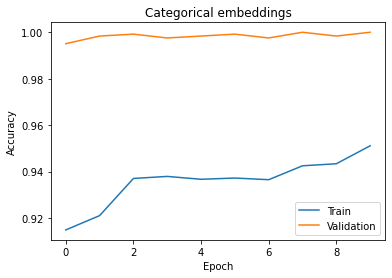

              precision    recall  f1-score   support

      Normal      0.998     1.000     0.999       621
   Poisonous      1.000     0.998     0.999       598

    accuracy                          0.999      1219
   macro avg      0.999     0.999     0.999      1219
weighted avg      0.999     0.999     0.999      1219



In [5]:
#Plot accuracies
plt.title('Categorical embeddings')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(range(epochs), run_acc_train)
plt.plot(range(epochs), run_acc_val)
plt.legend(['Train', 'Validation'])
plt.show()
#Load best trained model
model_path = './Embedding_models/20dimEmbed'
#model_path = './Embedding_models/20dimEmbedV2'
model = tf.keras.models.load_model(model_path)
predict=model.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()
print(classification_report(y_test, prediccion, target_names = ['Normal','Poisonous'], digits = 3))

### 2.4 Extract outputs from each layer

In [6]:
model = tf.keras.models.load_model(model_path)
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]   # evaluation function
#Calculate outputs of every layer for all dataset (we saved it as X)
layer_outs = [func([X]) for func in functors]
#Extract embeddings (the ones from the pre-classifier layer), which are the output of the 5th layer
embeds = layer_outs[5][0]
print(embeds[0])#Print embeddings for the first row

[0.0826568  3.273808   0.         1.6135509  0.3983796  0.631426
 0.18017048 0.         0.         1.2682958  1.5809033  0.
 0.         1.3436277  0.08414925 2.362726   2.063879   0.16523372
 1.7935406  0.49763924 0.48627543 1.6165504  0.         0.
 0.6040825  0.         0.         0.         2.5458333  0.        ]


## 3. Clustering

Perform clustering over the original dataset and the embeddings to examine cluster purity.

In [7]:
from sklearn.cluster import KMeans, DBSCAN, Birch, OPTICS
from sklearn.metrics import silhouette_score, pairwise_distances

### 3.1 K-means over the original dataset

In [8]:
#Cluster and obtain labels
kmeans = KMeans(n_clusters=2, random_state = 273).fit(X)
clustering_kmeans = kmeans.labels_
#Calculate and print contingency table
data_crosstab = pd.crosstab(clustering_kmeans, y, margins = False, rownames = ['Cluster'], colnames = ['True labels'])
print(data_crosstab.transpose())
#Calculate and print purity
cm_kmeans = np.array(data_crosstab)
purity_kmeans = np.sum(np.amax(cm_kmeans, axis = 1))/np.sum(cm_kmeans)
print(f'Purity: {round(purity_kmeans, 6)}')
#Calculate silhouette score
sil_kmeans = silhouette_score(X, clustering_kmeans, metric='euclidean')
print(f'Silhouette score: {sil_kmeans}')

Cluster         0     1
True labels            
0              31  4177
1            3096   820
Purity: 0.895249
Silhouette score: 0.16421449550117176


### 3.2 K-means over the embeddings

In [9]:
#Cluster and obtain labels
kmeans = KMeans(n_clusters=2, random_state = 273).fit(embeds)
clustering_kmeans = kmeans.labels_
#Calculate and print contingency table
data_crosstab = pd.crosstab(clustering_kmeans, y, margins = False, rownames = ['Cluster'], colnames = ['True labels'])
print(data_crosstab.transpose())
#Calculate and print purity
cm_kmeans = np.array(data_crosstab)
purity_kmeans = np.sum(np.amax(cm_kmeans, axis = 1))/np.sum(cm_kmeans)
print(f'Purity: {round(purity_kmeans, 6)}')
#Calculate silhouette score
sil_kmeans = silhouette_score(embeds, clustering_kmeans, metric='euclidean')
print(f'Silhouette score: {sil_kmeans}')
#Iterate over the columns (cluster assignments) and select the ones that are impure
impure_clust = None
for i in range(data_crosstab.shape[1]):
    if(0 not in tuple(data_crosstab.iloc[i,:])):
        impure_clust = i
print(f"Impure cluster: {impure_clust}")

Cluster         0     1
True labels            
0               0  4208
1            3908     8
Purity: 0.999015
Silhouette score: 0.5427473187446594
Impure cluster: 1


The use of embeddings has massively improved the result, turning the initial 851 impure points into only 8.

Increasing the amount of clusters reduces the silhouette score, but does not alter the purity score significantly.

## 4. Anomaly visualization

Often, when a dataset has a low dimensionality, it is possible to visually identify outlier candidates. Before jumping into more complex algorithms, let's try to visualize our dataset.

### 4.1 Embedding visualization

Even if the embeddings are somewhat abstract, they can still be helpful as a visualization tool. Before performing a PCA or SVD, let's plot the first 3 embedding dimensions. As clusters seem to be very pure, embeddings must properly separate both classes, as observed in the following plot:

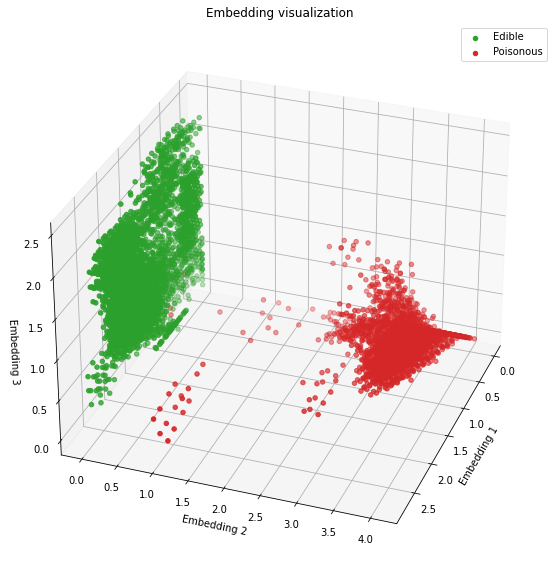

In [10]:
m1 = embeds[np.where(y == 0)[0],:3]
m2 = embeds[np.where(y == 1)[0],:3]
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 20)#Elevation, azimuth
ax.scatter(m1[:,0],m1[:,1],m1[:,2], label = 'Edible', color='tab:green')
ax.scatter(m2[:,0],m2[:,1],m2[:,2], label = 'Poisonous', color='tab:red')
ax.set_xlabel('Embedding 1')
ax.set_ylabel('Embedding 2')
ax.set_zlabel('Embedding 3')
plt.legend()
plt.title('Embedding visualization')
plt.show()

### 4.2 Embedding visualization with PCA

Let's perform a PCA to see if it is possible to visualize the class separation making use of all embedding dimensions.

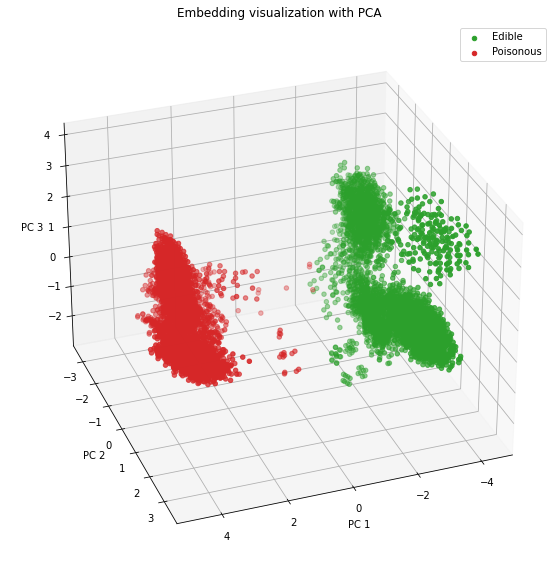

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3, random_state=273)
embeds_pca = pca.fit_transform(embeds)
m1 = embeds_pca[np.where(y == 0)[0],:]
m2 = embeds_pca[np.where(y == 1)[0],:]
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 70)#Elevation, azimuth
ax.scatter(m1[:,0],m1[:,1],m1[:,2], label = 'Edible', color='tab:green')
ax.scatter(m2[:,0],m2[:,1],m2[:,2], label = 'Poisonous', color='tab:red')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.title('Embedding visualization with PCA')
plt.show()

With PCA, both classes are clearly separable. Both of them seem to have a complex structure with sub-clusters (seen better by changing the azimuth variable in the view_init function). The region in the middle may be the one that hosts more outliers for both classes.

### 4.3 Embedding visualization with SVD

Let's try to perform an SVD and compare it to the PCA.

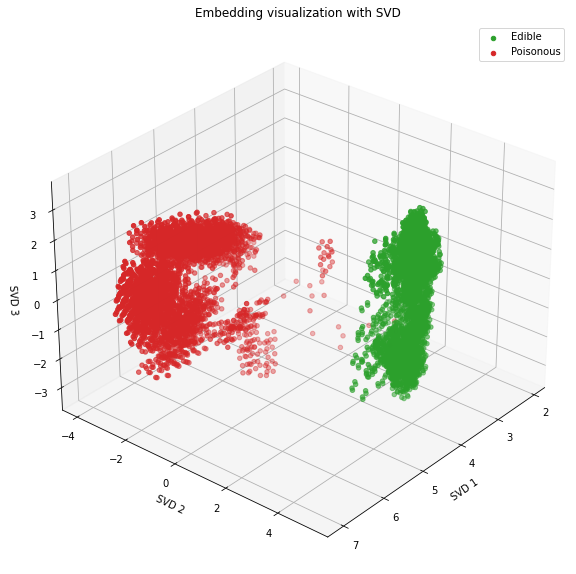

In [12]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 3, n_iter=10, random_state=273)
embeds_svd = svd.fit_transform(embeds)
m1 = embeds_svd[np.where(y == 0)[0],:]
m2 = embeds_svd[np.where(y == 1)[0],:]
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 40)#Elevation, azimuth
ax.scatter(m1[:,0],m1[:,1],m1[:,2], label = 'Edible', color='tab:green')
ax.scatter(m2[:,0],m2[:,1],m2[:,2], label = 'Poisonous', color='tab:red')
ax.set_xlabel('SVD 1')
ax.set_ylabel('SVD 2')
ax.set_zlabel('SVD 3')
plt.legend()
plt.title('Embedding visualization with SVD')
plt.show()

Structures still appear to be separable, but the poisonous class is less compact, and some points could be easily labeled as edible because of their proximity to the other class.

## 5. Anomaly detection

We will now start using our custom outlier detection class. We will focus exclusively on the cluster with known impurities, but we could apply the result to the other cluster, in case we would like to study the behaviour of each algorithm.

### 5.1 Pre-processing

In [13]:
#Look at impure cluster in all representations
idx = np.where(clustering_kmeans == impure_clust)[0]
embeds_imp = embeds[idx,:]
embeds_imp_pca = embeds_pca[idx,:]
embeds_imp_svd = embeds_svd[idx,:]
#Extract impure points
id_clust = np.where(clustering_kmeans == impure_clust)[0]#
id_true = np.where(y == 1)[0]
outliers = np.array([idt for idt in id_true if idt in id_clust])
print(outliers)
#Select outliers inside dataset
point_outliers = embeds[outliers]
#Find the point outliers in the cluster
outliers_clust = []
for i in range(len(point_outliers)):
    outliers_clust.append(np.where((embeds_imp == point_outliers[i]).all(axis=1))[0])
outliers_clust = np.array(outliers_clust).flatten()
print(outliers_clust)
#Split the points between missclassified and correct
other_points_emb = embeds_imp.copy()
other_points_emb = np.delete(other_points_emb, outliers_clust, axis = 0)
miss_points_emb = embeds_imp[outliers_clust]
other_points_pca = embeds_imp_pca.copy()
other_points_pca = np.delete(other_points_pca, outliers_clust, axis = 0)
miss_points_pca = embeds_imp_pca[outliers_clust]
other_points_svd = embeds_imp_svd.copy()
other_points_svd = np.delete(other_points_svd, outliers_clust, axis = 0)
miss_points_svd = embeds_imp_svd[outliers_clust]
#Select points for plotting: (3 first embedding dims, PCA and SVD)
m1_emb = other_points_emb[:,:3]
m2_emb = miss_points_emb[:,:3]
m1_pca = other_points_pca
m2_pca = miss_points_pca
m1_svd = other_points_svd
m2_svd = miss_points_svd

[4364 5107 5128 5237 5281 5361 5508 5717]
[3374 3456 3461 3488 3498 3518 3551 3616]


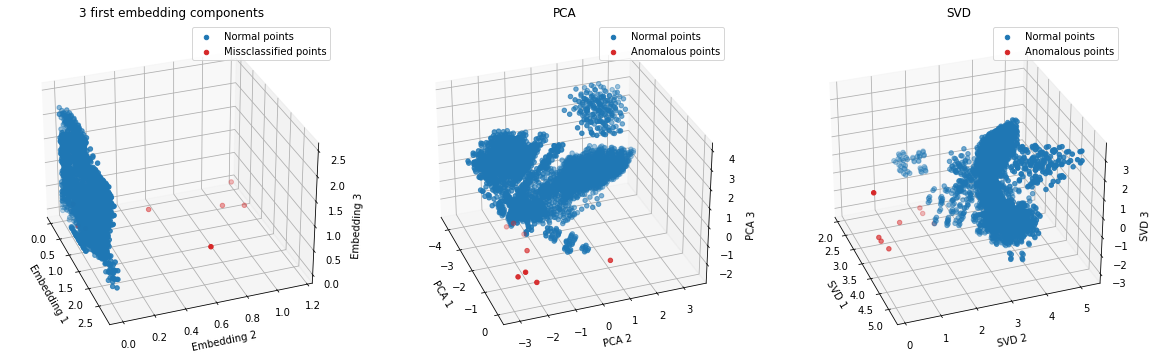

In [14]:
#Combine both plots
fig = plt.figure(figsize=(20,10))
#First plot
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.view_init(30, -20)#Elevation, azimuth
ax.scatter(m1_emb[:,0],m1_emb[:,1],m1_emb[:,2], label = 'Normal points', color='tab:blue')
ax.scatter(m2_emb[:,0],m2_emb[:,1],m2_emb[:,2], label = 'Missclassified points', color='tab:red')
ax.set_xlabel('Embedding 1')
ax.set_ylabel('Embedding 2')
ax.set_zlabel('Embedding 3')
ax.title.set_text('3 first embedding components')
ax.legend()
#Second plot
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.view_init(30, -20)
ax1.scatter(m1_pca[:,0],m1_pca[:,1],m1_pca[:,2], label = 'Normal points', color='tab:blue')
ax1.scatter(m2_pca[:,0],m2_pca[:,1],m2_pca[:,2], label = 'Anomalous points', color='tab:red')
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_zlabel('PCA 3')
ax1.title.set_text('PCA')
ax1.legend()
#Third plot
ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.view_init(30, -20)
ax2.scatter(m1_svd[:,0],m1_svd[:,1],m1_svd[:,2], label = 'Normal points', color='tab:blue')
ax2.scatter(m2_svd[:,0],m2_svd[:,1],m2_svd[:,2], label = 'Anomalous points', color='tab:red')
ax2.set_xlabel('SVD 1')
ax2.set_ylabel('SVD 2')
ax2.set_zlabel('SVD 3')
ax2.title.set_text('SVD')
ax2.legend()
plt.show()

The anomalous points belong to the other class, and it can be seen why, in some cases.

### 5.2 Common model parameters

Before running any model, let's define the common parameters that all models share, so that we do not have to modify them individually every time. (The most important parameter is contamination, which will be shared by all models). Every instance of the find_outliers class should be applied to a different cluster, as well as a different folder to save the models. (That is, if we wanted to analyze two clusters, and perform embedding, pca and svd analysis, we wolud need 6 instances in total)

In [15]:
from AnomalyDetection import find_outliers
contamination = 0.005
#contamination = 8
#Perform an analysis for all representations
fo_emb = find_outliers(data = embeds_imp, contamination = contamination, modelPath = './ClusterAnomalyModels/ODModels_ClusterMushroom')
fo_pca = find_outliers(data = embeds_imp_pca, contamination = contamination, modelPath = './ClusterAnomalyModels/ODModels_ClusterMushroomPCA')
fo_svd = find_outliers(data = embeds_imp_svd, contamination = contamination, modelPath = './ClusterAnomalyModels/ODModels_ClusterMushroomSVD')

Saving models at: /home/jverdu/SB_NLP/AnomalyDetection2/./ClusterAnomalyModels/ODModels_ClusterMushroom
Saving models at: /home/jverdu/SB_NLP/AnomalyDetection2/./ClusterAnomalyModels/ODModels_ClusterMushroomPCA
Saving models at: /home/jverdu/SB_NLP/AnomalyDetection2/./ClusterAnomalyModels/ODModels_ClusterMushroomSVD


### 5.3 Elliptic Envelope

In [16]:
#Apply elliptic envelope model to obtain outliers
preds_emb, scores_emb = fo_emb.elliptic_envelope()
preds_pca, scores_pca = fo_pca.elliptic_envelope()
preds_svd, scores_svd = fo_svd.elliptic_envelope()
#Select anomalous points
norm_points_emb = np.where(preds_emb == 1)[0]
anom_points_emb = np.where(preds_emb == -1)[0]
norm_points_pca = np.where(preds_pca == 1)[0]
anom_points_pca = np.where(preds_pca == -1)[0]
norm_points_svd = np.where(preds_svd == 1)[0]
anom_points_svd = np.where(preds_svd == -1)[0]
m3_imp = embeds_imp[norm_points_emb,:3]
m4_imp = embeds_imp[anom_points_emb,:3]
m3_imp_pca = embeds_imp_pca[norm_points_pca,:]
m4_imp_pca = embeds_imp_pca[anom_points_pca,:]
m3_imp_svd = embeds_imp_svd[norm_points_svd,:]
m4_imp_svd = embeds_imp_svd[anom_points_svd,:]

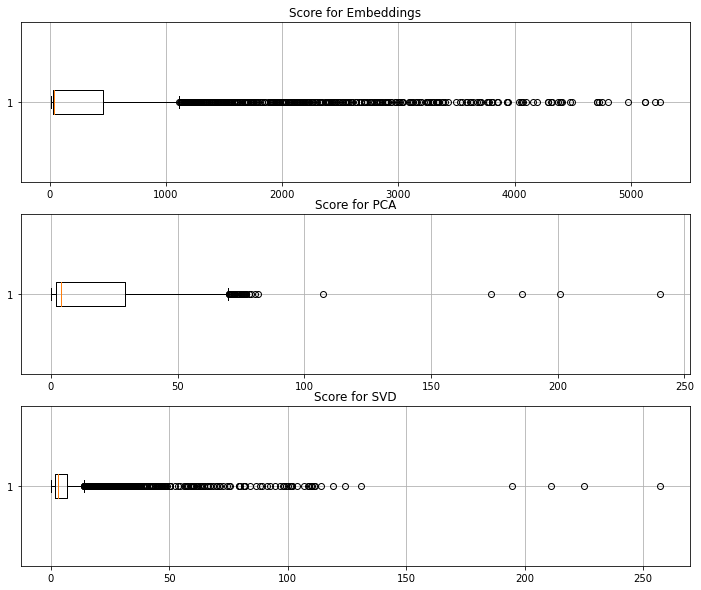

In [17]:
#Plot score boxplot
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot(3, 1, 1)
ax.boxplot(scores_emb, vert=False)
ax.title.set_text('Score for Embeddings')
ax.grid()
ax1 = fig.add_subplot(3, 1, 2)
ax1.boxplot(scores_pca, vert=False)
ax1.title.set_text('Score for PCA')
ax1.grid()
ax2 = fig.add_subplot(3, 1, 3)
ax2.boxplot(scores_svd, vert=False)
ax2.title.set_text('Score for SVD')
ax2.grid()
plt.show()

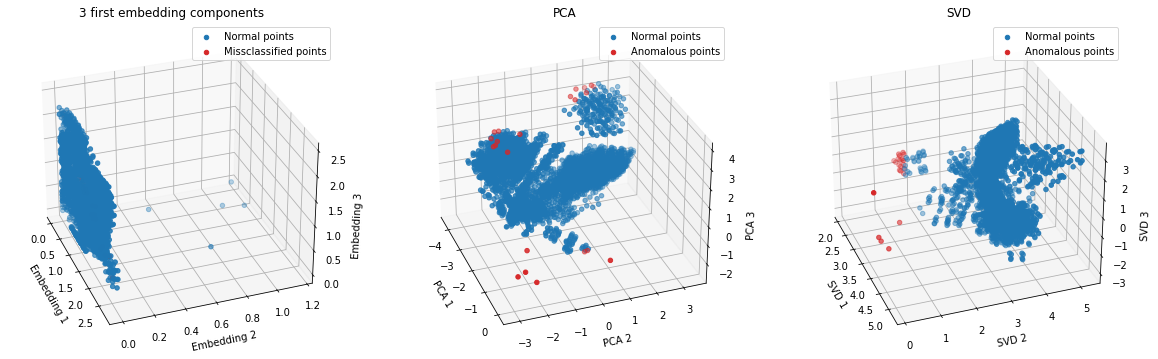

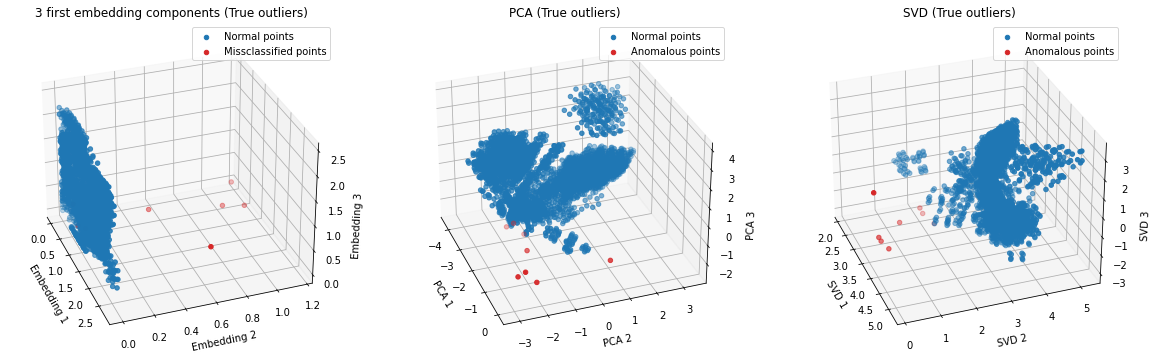

In [18]:
#Combine both plots
fig = plt.figure(figsize=(20,10))
#First plot
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.view_init(30, -20)#Elevation, azimuth
ax.scatter(m3_imp[:,0],m3_imp[:,1],m3_imp[:,2], label = 'Normal points', color='tab:blue')
ax.scatter(m4_imp[:,0],m4_imp[:,1],m4_imp[:,2], label = 'Missclassified points', color='tab:red')
ax.set_xlabel('Embedding 1')
ax.set_ylabel('Embedding 2')
ax.set_zlabel('Embedding 3')
ax.title.set_text('3 first embedding components')
ax.legend()
#Second plot
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.view_init(30, -20)
ax1.scatter(m3_imp_pca[:,0],m3_imp_pca[:,1],m3_imp_pca[:,2], label = 'Normal points', color='tab:blue')
ax1.scatter(m4_imp_pca[:,0],m4_imp_pca[:,1],m4_imp_pca[:,2], label = 'Anomalous points', color='tab:red')
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_zlabel('PCA 3')
ax1.title.set_text('PCA')
ax1.legend()
#Third plot
ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.view_init(30, -20)
ax2.scatter(m3_imp_svd[:,0],m3_imp_svd[:,1],m3_imp_svd[:,2], label = 'Normal points', color='tab:blue')
ax2.scatter(m4_imp_svd[:,0],m4_imp_svd[:,1],m4_imp_svd[:,2], label = 'Anomalous points', color='tab:red')
ax2.set_xlabel('SVD 1')
ax2.set_ylabel('SVD 2')
ax2.set_zlabel('SVD 3')
ax2.title.set_text('SVD')
ax2.legend()
plt.show()
#Show plots with true ourliers below
fig = plt.figure(figsize=(20,10))
#First plot
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.view_init(30, -20)#Elevation, azimuth
ax.scatter(m1_emb[:,0],m1_emb[:,1],m1_emb[:,2], label = 'Normal points', color='tab:blue')
ax.scatter(m2_emb[:,0],m2_emb[:,1],m2_emb[:,2], label = 'Missclassified points', color='tab:red')
ax.set_xlabel('Embedding 1')
ax.set_ylabel('Embedding 2')
ax.set_zlabel('Embedding 3')
ax.title.set_text('3 first embedding components (True outliers)')
ax.legend()
#Second plot
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.view_init(30, -20)
ax1.scatter(m1_pca[:,0],m1_pca[:,1],m1_pca[:,2], label = 'Normal points', color='tab:blue')
ax1.scatter(m2_pca[:,0],m2_pca[:,1],m2_pca[:,2], label = 'Anomalous points', color='tab:red')
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_zlabel('PCA 3')
ax1.title.set_text('PCA (True outliers)')
ax1.legend()
#Third plot
ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.view_init(30, -20)
ax2.scatter(m1_svd[:,0],m1_svd[:,1],m1_svd[:,2], label = 'Normal points', color='tab:blue')
ax2.scatter(m2_svd[:,0],m2_svd[:,1],m2_svd[:,2], label = 'Anomalous points', color='tab:red')
ax2.set_xlabel('SVD 1')
ax2.set_ylabel('SVD 2')
ax2.set_zlabel('SVD 3')
ax2.title.set_text('SVD (True outliers)')
ax2.legend()
plt.show()

### 5.4 Isolation forest

In [19]:
#Apply isolation forest model to obtain outliers
preds_emb, scores_emb = fo_emb.isolation_forest()
preds_pca, scores_pca = fo_pca.isolation_forest()
preds_svd, scores_svd = fo_svd.isolation_forest()
#Select anomalous points
norm_points_emb = np.where(preds_emb == 1)[0]
anom_points_emb = np.where(preds_emb == -1)[0]
norm_points_pca = np.where(preds_pca == 1)[0]
anom_points_pca = np.where(preds_pca == -1)[0]
norm_points_svd = np.where(preds_svd == 1)[0]
anom_points_svd = np.where(preds_svd == -1)[0]
m3_imp = embeds_imp[norm_points_emb,:3]
m4_imp = embeds_imp[anom_points_emb,:3]
m3_imp_pca = embeds_imp_pca[norm_points_pca,:]
m4_imp_pca = embeds_imp_pca[anom_points_pca,:]
m3_imp_svd = embeds_imp_svd[norm_points_svd,:]
m4_imp_svd = embeds_imp_svd[anom_points_svd,:]

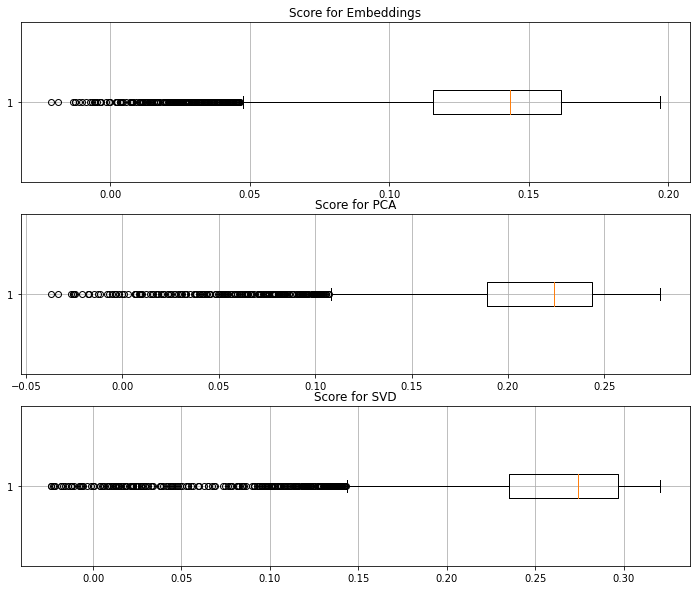

In [20]:
#Plot score boxplot
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot(3, 1, 1)
ax.boxplot(scores_emb, vert=False)
ax.title.set_text('Score for Embeddings')
ax.grid()
ax1 = fig.add_subplot(3, 1, 2)
ax1.boxplot(scores_pca, vert=False)
ax1.title.set_text('Score for PCA')
ax1.grid()
ax2 = fig.add_subplot(3, 1, 3)
ax2.boxplot(scores_svd, vert=False)
ax2.title.set_text('Score for SVD')
ax2.grid()
plt.show()

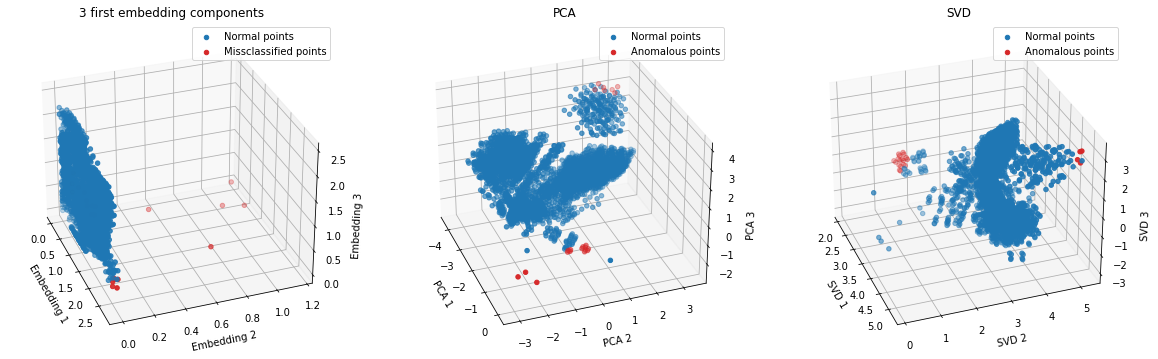

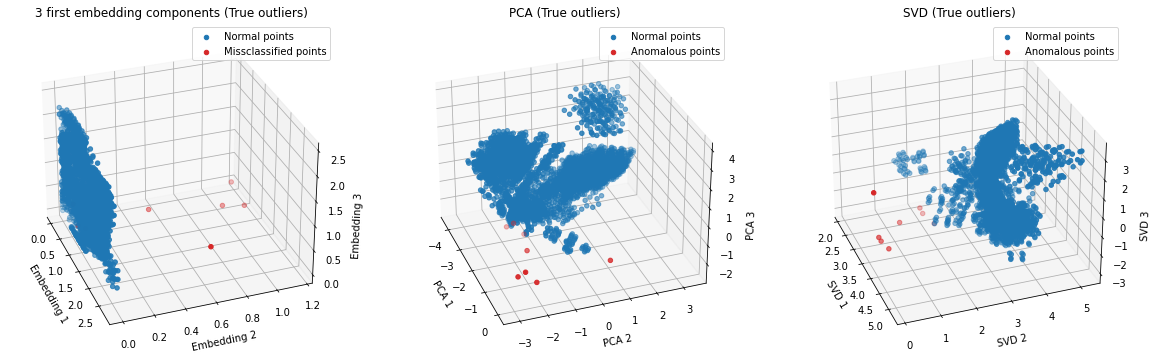

In [21]:
#Combine both plots
fig = plt.figure(figsize=(20,10))
#First plot
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.view_init(30, -20)#Elevation, azimuth
ax.scatter(m3_imp[:,0],m3_imp[:,1],m3_imp[:,2], label = 'Normal points', color='tab:blue')
ax.scatter(m4_imp[:,0],m4_imp[:,1],m4_imp[:,2], label = 'Missclassified points', color='tab:red')
ax.set_xlabel('Embedding 1')
ax.set_ylabel('Embedding 2')
ax.set_zlabel('Embedding 3')
ax.title.set_text('3 first embedding components')
ax.legend()
#Second plot
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.view_init(30, -20)
ax1.scatter(m3_imp_pca[:,0],m3_imp_pca[:,1],m3_imp_pca[:,2], label = 'Normal points', color='tab:blue')
ax1.scatter(m4_imp_pca[:,0],m4_imp_pca[:,1],m4_imp_pca[:,2], label = 'Anomalous points', color='tab:red')
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_zlabel('PCA 3')
ax1.title.set_text('PCA')
ax1.legend()
#Third plot
ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.view_init(30, -20)
ax2.scatter(m3_imp_svd[:,0],m3_imp_svd[:,1],m3_imp_svd[:,2], label = 'Normal points', color='tab:blue')
ax2.scatter(m4_imp_svd[:,0],m4_imp_svd[:,1],m4_imp_svd[:,2], label = 'Anomalous points', color='tab:red')
ax2.set_xlabel('SVD 1')
ax2.set_ylabel('SVD 2')
ax2.set_zlabel('SVD 3')
ax2.title.set_text('SVD')
ax2.legend()
plt.show()
#Show plots with true ourliers below
fig = plt.figure(figsize=(20,10))
#First plot
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.view_init(30, -20)#Elevation, azimuth
ax.scatter(m1_emb[:,0],m1_emb[:,1],m1_emb[:,2], label = 'Normal points', color='tab:blue')
ax.scatter(m2_emb[:,0],m2_emb[:,1],m2_emb[:,2], label = 'Missclassified points', color='tab:red')
ax.set_xlabel('Embedding 1')
ax.set_ylabel('Embedding 2')
ax.set_zlabel('Embedding 3')
ax.title.set_text('3 first embedding components (True outliers)')
ax.legend()
#Second plot
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.view_init(30, -20)
ax1.scatter(m1_pca[:,0],m1_pca[:,1],m1_pca[:,2], label = 'Normal points', color='tab:blue')
ax1.scatter(m2_pca[:,0],m2_pca[:,1],m2_pca[:,2], label = 'Anomalous points', color='tab:red')
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_zlabel('PCA 3')
ax1.title.set_text('PCA (True outliers)')
ax1.legend()
#Third plot
ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.view_init(30, -20)
ax2.scatter(m1_svd[:,0],m1_svd[:,1],m1_svd[:,2], label = 'Normal points', color='tab:blue')
ax2.scatter(m2_svd[:,0],m2_svd[:,1],m2_svd[:,2], label = 'Anomalous points', color='tab:red')
ax2.set_xlabel('SVD 1')
ax2.set_ylabel('SVD 2')
ax2.set_zlabel('SVD 3')
ax2.title.set_text('SVD (True outliers)')
ax2.legend()
plt.show()

### 5.5 OC-SVM

In [22]:
#Apply isolation forest model to obtain outliers
preds_emb, scores_emb = fo_emb.oc_svm(gamma=0.1)
preds_pca, scores_pca = fo_pca.oc_svm(gamma=0.1)
preds_svd, scores_svd = fo_svd.oc_svm(gamma=0.1)
#Select anomalous points
norm_points_emb = np.where(preds_emb == 1)[0]
anom_points_emb = np.where(preds_emb == -1)[0]
norm_points_pca = np.where(preds_pca == 1)[0]
anom_points_pca = np.where(preds_pca == -1)[0]
norm_points_svd = np.where(preds_svd == 1)[0]
anom_points_svd = np.where(preds_svd == -1)[0]
m3_imp = embeds_imp[norm_points_emb,:3]
m4_imp = embeds_imp[anom_points_emb,:3]
m3_imp_pca = embeds_imp_pca[norm_points_pca,:]
m4_imp_pca = embeds_imp_pca[anom_points_pca,:]
m3_imp_svd = embeds_imp_svd[norm_points_svd,:]
m4_imp_svd = embeds_imp_svd[anom_points_svd,:]

/home/jverdu/anaconda3/envs/AnomalyDetection2/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/jverdu/anaconda3/envs/AnomalyDetection2/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/jverdu/anaconda3/envs/AnomalyDetection2/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


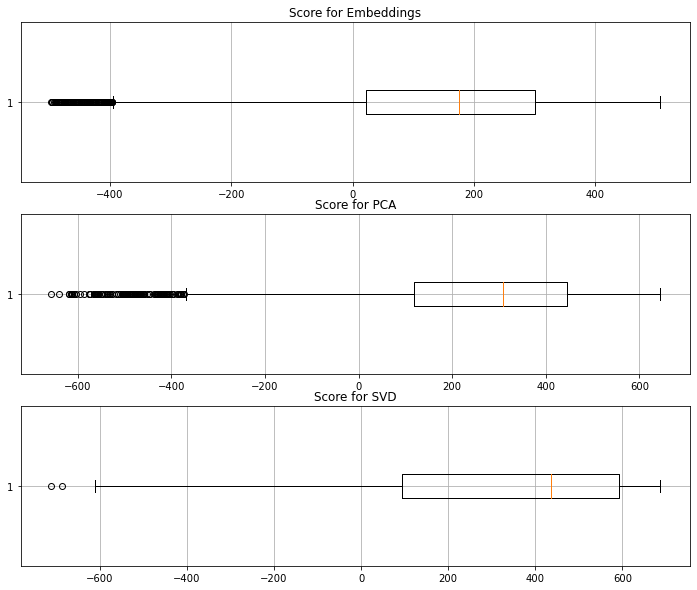

In [23]:
#Plot score boxplot
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot(3, 1, 1)
ax.boxplot(scores_emb, vert=False)
ax.title.set_text('Score for Embeddings')
ax.grid()
ax1 = fig.add_subplot(3, 1, 2)
ax1.boxplot(scores_pca, vert=False)
ax1.title.set_text('Score for PCA')
ax1.grid()
ax2 = fig.add_subplot(3, 1, 3)
ax2.boxplot(scores_svd, vert=False)
ax2.title.set_text('Score for SVD')
ax2.grid()
plt.show()

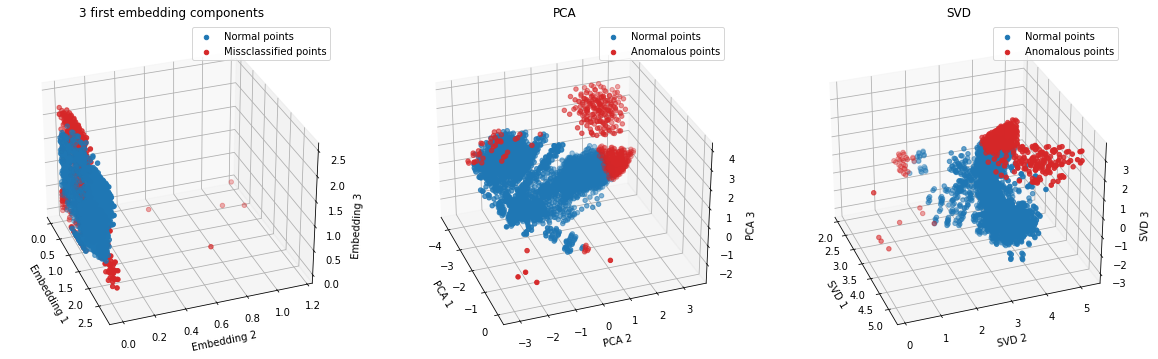

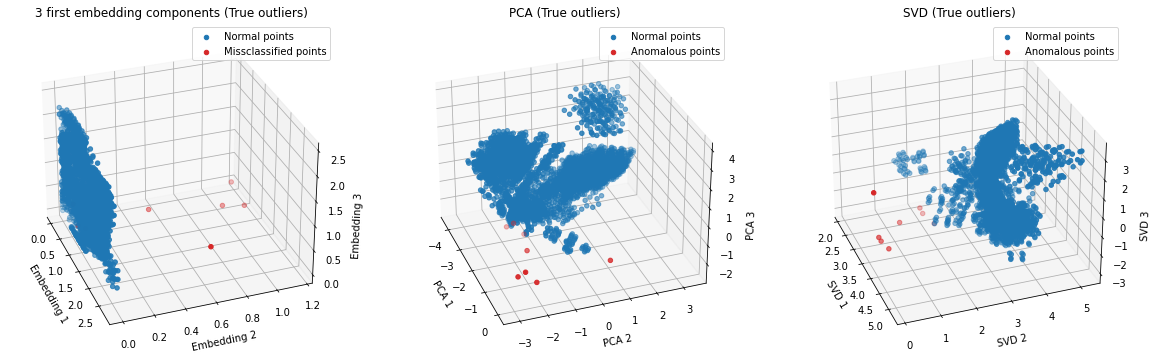

In [24]:
#Combine both plots
fig = plt.figure(figsize=(20,10))
#First plot
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.view_init(30, -20)#Elevation, azimuth
ax.scatter(m3_imp[:,0],m3_imp[:,1],m3_imp[:,2], label = 'Normal points', color='tab:blue')
ax.scatter(m4_imp[:,0],m4_imp[:,1],m4_imp[:,2], label = 'Missclassified points', color='tab:red')
ax.set_xlabel('Embedding 1')
ax.set_ylabel('Embedding 2')
ax.set_zlabel('Embedding 3')
ax.title.set_text('3 first embedding components')
ax.legend()
#Second plot
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.view_init(30, -20)
ax1.scatter(m3_imp_pca[:,0],m3_imp_pca[:,1],m3_imp_pca[:,2], label = 'Normal points', color='tab:blue')
ax1.scatter(m4_imp_pca[:,0],m4_imp_pca[:,1],m4_imp_pca[:,2], label = 'Anomalous points', color='tab:red')
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_zlabel('PCA 3')
ax1.title.set_text('PCA')
ax1.legend()
#Third plot
ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.view_init(30, -20)
ax2.scatter(m3_imp_svd[:,0],m3_imp_svd[:,1],m3_imp_svd[:,2], label = 'Normal points', color='tab:blue')
ax2.scatter(m4_imp_svd[:,0],m4_imp_svd[:,1],m4_imp_svd[:,2], label = 'Anomalous points', color='tab:red')
ax2.set_xlabel('SVD 1')
ax2.set_ylabel('SVD 2')
ax2.set_zlabel('SVD 3')
ax2.title.set_text('SVD')
ax2.legend()
plt.show()
#Show plots with true ourliers below
fig = plt.figure(figsize=(20,10))
#First plot
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.view_init(30, -20)#Elevation, azimuth
ax.scatter(m1_emb[:,0],m1_emb[:,1],m1_emb[:,2], label = 'Normal points', color='tab:blue')
ax.scatter(m2_emb[:,0],m2_emb[:,1],m2_emb[:,2], label = 'Missclassified points', color='tab:red')
ax.set_xlabel('Embedding 1')
ax.set_ylabel('Embedding 2')
ax.set_zlabel('Embedding 3')
ax.title.set_text('3 first embedding components (True outliers)')
ax.legend()
#Second plot
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.view_init(30, -20)
ax1.scatter(m1_pca[:,0],m1_pca[:,1],m1_pca[:,2], label = 'Normal points', color='tab:blue')
ax1.scatter(m2_pca[:,0],m2_pca[:,1],m2_pca[:,2], label = 'Anomalous points', color='tab:red')
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_zlabel('PCA 3')
ax1.title.set_text('PCA (True outliers)')
ax1.legend()
#Third plot
ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.view_init(30, -20)
ax2.scatter(m1_svd[:,0],m1_svd[:,1],m1_svd[:,2], label = 'Normal points', color='tab:blue')
ax2.scatter(m2_svd[:,0],m2_svd[:,1],m2_svd[:,2], label = 'Anomalous points', color='tab:red')
ax2.set_xlabel('SVD 1')
ax2.set_ylabel('SVD 2')
ax2.set_zlabel('SVD 3')
ax2.title.set_text('SVD (True outliers)')
ax2.legend()
plt.show()

### 5.6 Local outlier factor

In [25]:
#Apply isolation forest model to obtain outliers
preds_emb, scores_emb = fo_emb.local_outlier_factor(metric='euclidean')
preds_pca, scores_pca = fo_pca.local_outlier_factor(metric='euclidean')
preds_svd, scores_svd = fo_svd.local_outlier_factor(metric='euclidean')
#Select anomalous points
norm_points_emb = np.where(preds_emb == 1)[0]
anom_points_emb = np.where(preds_emb == -1)[0]
norm_points_pca = np.where(preds_pca == 1)[0]
anom_points_pca = np.where(preds_pca == -1)[0]
norm_points_svd = np.where(preds_svd == 1)[0]
anom_points_svd = np.where(preds_svd == -1)[0]
m3_imp = embeds_imp[norm_points_emb,:3]
m4_imp = embeds_imp[anom_points_emb,:3]
m3_imp_pca = embeds_imp_pca[norm_points_pca,:]
m4_imp_pca = embeds_imp_pca[anom_points_pca,:]
m3_imp_svd = embeds_imp_svd[norm_points_svd,:]
m4_imp_svd = embeds_imp_svd[anom_points_svd,:]

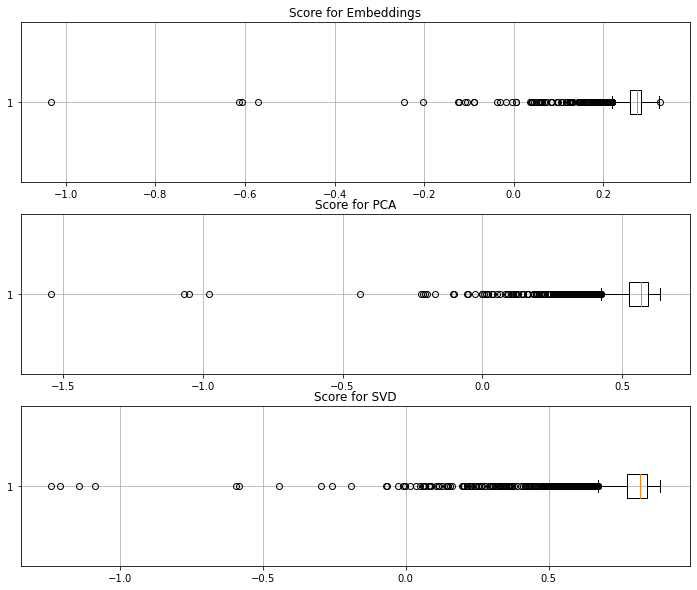

In [26]:
#Plot score boxplot
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot(3, 1, 1)
ax.boxplot(scores_emb, vert=False)
ax.title.set_text('Score for Embeddings')
ax.grid()
ax1 = fig.add_subplot(3, 1, 2)
ax1.boxplot(scores_pca, vert=False)
ax1.title.set_text('Score for PCA')
ax1.grid()
ax2 = fig.add_subplot(3, 1, 3)
ax2.boxplot(scores_svd, vert=False)
ax2.title.set_text('Score for SVD')
ax2.grid()
plt.show()

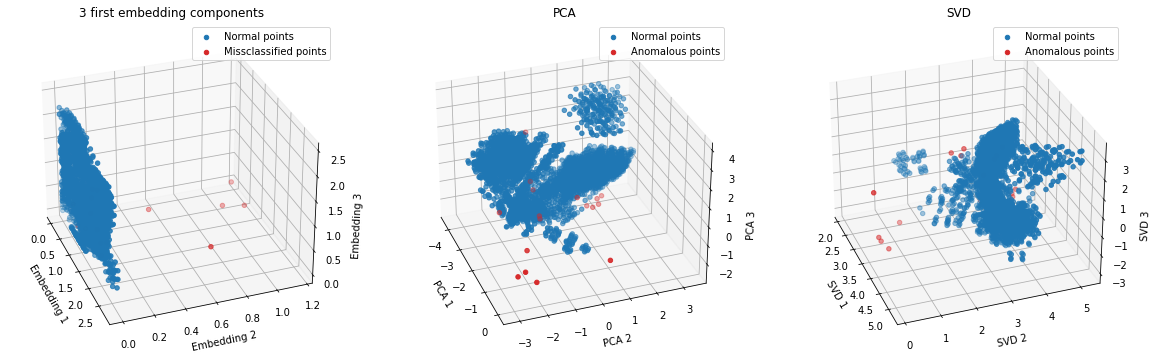

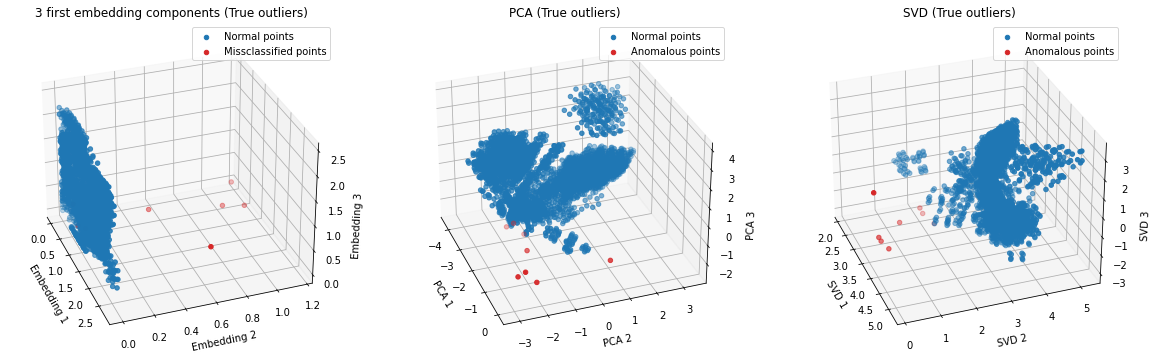

In [27]:
#Combine both plots
fig = plt.figure(figsize=(20,10))
#First plot
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.view_init(30, -20)#Elevation, azimuth
ax.scatter(m3_imp[:,0],m3_imp[:,1],m3_imp[:,2], label = 'Normal points', color='tab:blue')
ax.scatter(m4_imp[:,0],m4_imp[:,1],m4_imp[:,2], label = 'Missclassified points', color='tab:red')
ax.set_xlabel('Embedding 1')
ax.set_ylabel('Embedding 2')
ax.set_zlabel('Embedding 3')
ax.title.set_text('3 first embedding components')
ax.legend()
#Second plot
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.view_init(30, -20)
ax1.scatter(m3_imp_pca[:,0],m3_imp_pca[:,1],m3_imp_pca[:,2], label = 'Normal points', color='tab:blue')
ax1.scatter(m4_imp_pca[:,0],m4_imp_pca[:,1],m4_imp_pca[:,2], label = 'Anomalous points', color='tab:red')
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_zlabel('PCA 3')
ax1.title.set_text('PCA')
ax1.legend()
#Third plot
ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.view_init(30, -20)
ax2.scatter(m3_imp_svd[:,0],m3_imp_svd[:,1],m3_imp_svd[:,2], label = 'Normal points', color='tab:blue')
ax2.scatter(m4_imp_svd[:,0],m4_imp_svd[:,1],m4_imp_svd[:,2], label = 'Anomalous points', color='tab:red')
ax2.set_xlabel('SVD 1')
ax2.set_ylabel('SVD 2')
ax2.set_zlabel('SVD 3')
ax2.title.set_text('SVD')
ax2.legend()
plt.show()
#Show plots with true ourliers below
fig = plt.figure(figsize=(20,10))
#First plot
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.view_init(30, -20)#Elevation, azimuth
ax.scatter(m1_emb[:,0],m1_emb[:,1],m1_emb[:,2], label = 'Normal points', color='tab:blue')
ax.scatter(m2_emb[:,0],m2_emb[:,1],m2_emb[:,2], label = 'Missclassified points', color='tab:red')
ax.set_xlabel('Embedding 1')
ax.set_ylabel('Embedding 2')
ax.set_zlabel('Embedding 3')
ax.title.set_text('3 first embedding components (True outliers)')
ax.legend()
#Second plot
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.view_init(30, -20)
ax1.scatter(m1_pca[:,0],m1_pca[:,1],m1_pca[:,2], label = 'Normal points', color='tab:blue')
ax1.scatter(m2_pca[:,0],m2_pca[:,1],m2_pca[:,2], label = 'Anomalous points', color='tab:red')
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_zlabel('PCA 3')
ax1.title.set_text('PCA (True outliers)')
ax1.legend()
#Third plot
ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.view_init(30, -20)
ax2.scatter(m1_svd[:,0],m1_svd[:,1],m1_svd[:,2], label = 'Normal points', color='tab:blue')
ax2.scatter(m2_svd[:,0],m2_svd[:,1],m2_svd[:,2], label = 'Anomalous points', color='tab:red')
ax2.set_xlabel('SVD 1')
ax2.set_ylabel('SVD 2')
ax2.set_zlabel('SVD 3')
ax2.title.set_text('SVD (True outliers)')
ax2.legend()
plt.show()

## 6. Closing remarks

Categorical embeddings appear to be an useful option when dealing with datasets that have a large portion of categorical variables. Most anomaly detection algorithms do not handle well categorical data, so this alternative provides a possible strong solution.

The local outlier factor is probably the best model, as it can work properly even when the data has variable density or complex shapes, and it only looks at the k nearby neighbors of a point to determine if it is an outlier or not. 
The isolation forest is also a nice, fast alternative, while the elliptic envelope works remarkably well as long as the studied cluster follows a gaussian distribution.

The One-class SVM works best as a novel detection model, but even so, tends to overfit and has a large amount of parameters, so it is probably the worst option.

Even after all of this, anomaly detection will be heavily influenced by the chosen clustering algorithm. Most of these algorithms tend to experience problems with categorical data (unlike ROCK, among others), so the use of categorical embeddings may help the entire process.

### 6.1 Custom anomaly score

As a last comment, in case a custom anomaly detection model is built, I came up with a metric that takes into account both categorical and numerical features:

The main idea of this method is to calculate two similarity matrices. One for continuous attributes ($N_{ij}$) and another one for categorical attributes ($C_{ij}$). These matrices are then combined in the following way:

$$ S_{ij} = N_{ij} \cdot (1 + wC_{ij})$$

Where $N_{ij}$ is a distance matrix, such as the euclidean distance, $C_{ij}$ is the jaccard distance (defined as $1 - J_{ij}$, where $J_{ij}$ is the jaccard index) and $w$ is a scaling parameter, that depends on the ratio of categorical-continuous variables in the dataset.

This similarity matrix can then be used for nearest-neighbor outlier detection methods, such as local outlier factor. In case the dataset has been clustered, the analysis has to be performed individually for each cluster.